# ENTRENANDO REDES NEURONALES PROFUNDAS

En el capítulo 10 presentamos las redes neuronales artificiales y entrenamos nuestras primeras redes neuronales profundas. Pero eran redes poco profundas, con solo algunas capas ocultas. ¿Y si necesitáramos abordar un problema complejo, como la detección de cientos de tipos de objetos en imágenes de alta resolución? Necesitamos entrenar DNNs mucho más profundas, quizás con 10 capas o muchas más, cada una conteniendo cientos de neuronas, unidas por centenares de miles de conexiones. Entrenar una DNN profunda no es un paseo por el parque. A continuación, se mencionan algunos de los problemas con los que podríamos encontrarnos:

+ Es posible que nos enfrentemos con el complicado problema de los *gradientes que se desvanecen* o con el problema relacionado de los *gradientes que explotan*. Esto es cuando los gradientes se hacen cada vez más pequeños o más y más grandes, cuando fluyen hacía atrás a través de la DNN durante el entrenamiento. Ambos problemas hacen que las capas inferiores sean muy difíciles de entrenar.

+ Es posible que no tengamos suficientes datos de entrenamiento para una red tan grande o podría ser muy costosa de etiquetar.

+ El entrenamiento podría ser extremadamente lento.

+ Un modelo con millones de parámetros correría un grave riesgo de sobreajustar el conjunto de entrenamiento, especialmente si no existen instancias de entrenamiento suficientes o si son demasiado ruidosas.

En este capítulo repasaremos cada uno de estos problemas y presentaremos técnicas para resolverlos. Empezaremos explorando el problema de los gradientes que se desvanecen y que estallan y algunos de sus soluciones más populares. Después, echaremos un vistazo al aprendizaje por transferencia y al preentrenamiento no supervisado, que nos ayudará a abordar tareas complejas aunque tengamos datos muy poco etiquetados.

Con estas herramientas seremos capaces de entrenar redes muy profundas. ¡Bienvenido al Deep Learning!

# Los problemas de los gradientes que se desvanecen y explotan

Como discutimos en el capítulo 10, el algoritmo de retropropagación funcionan yendo desde las capas de salida a las capas de entrada, propagando el gradiente de error a lo largo del camino. Una vez que el algoritmo ha calculado el gradiente de la función de coste con respecto a cada parámetro de la red, usa dichos gradientes para actualizar cada parámetro con un paso de Descenso de Gradiente.

Desafortunadamente, a menudo los gradientes se vuelven más y más pequeños a medida que el algoritmo desciende a las capas inferiores. Como resultado, la actualización del Descenso de Gradiente deja los pesos de las conexiones de las capas inferiores prácticamente sin cambio y el entrenamiento nunca converge a una buena solución. A esto lo denominamos  el problema de los *gradientes que se desvanecen*. En algunos casos, puede ocurrir lo contrario: los gradientes se hacen más y más grandes hasta que las capas sufren actualizaciones de pesos increiblemente grandes y el algoritmo diverge. Esto es el problema de los *gradientes que explotan*, que surge en la redes neuronales recurrentes. De manera más general, las redes neuronales profundas sufren de gradientes inestables; diferentes capas pueden aprender a velocidades muy diferentes.

Este comportamiento desafortunado se observó empíricamente hace bastante tiempo y fue una de las razones por las que se abandonaron las redes neuronales profundas a principios del 2000. No estaba claro qué causaba que los gradientes fueran tan inestables cuando se entrenaban DNNs, pero un [artículo de 2010](https://homl.info/47) de Xabier Glorot y Yoshua Bengio arrojó algo de luz. Los autores encontraron algunos sospechosos, incluida la combinación de la popular función de activación sigmoide logística y la técnica de inicialización de pesos que era más popular en ese tiempo (es decir, una distribución normal con una media de 0 y una desviación estándar de 1). Brevemente, mostraron que con esta función de activación y este esquema de inicialización, la varianza de las salidas de cada capa es mucho mayor que la varianza de sus entradas. Avanzando en la red, la varianza sigue aumentando después de cada capa hasta que la función de activación se sature en las capas superiores. Esta saturación en realidad se ve agravada por el hecho de que la función logística tiene una media de 0.5, no 0 (la función tangente hiperbólica tiene una media de 0 y se comporta ligeramente mejor que la función logística en redes profundas).

Al observar la función de activación logística (ver la siguiente figura), podemos ver que cuando las entradas se vuelven grandes (negativas o positivas), la función satura en 0 ó 1, con una derivada extremadamente cercana a 0. Por lo tanto, cuando la retropropagación se activa prácticamente no tiene gradiente para propagarse a través de la red y el poco gradiente que existe sigue diluyéndose a medida que la retropropagación progresa por las capas superiores, por lo que no queda nada para las capas inferiores.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

np.random.seed(42)

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

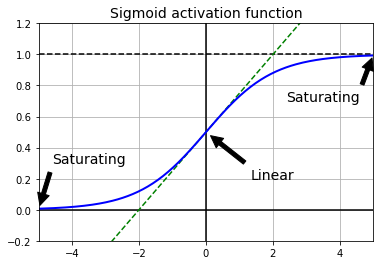

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Inicialización Glorot y He

En su artículo, Glorot y Bengio propusieron una forma de aliviar significativamente el problema de los gradientes inestables. Señalaron que necesitamos que la señal fluya correctamente en ambas direcciones: en la dirección de avance al hacer predicciones y en la dirección inversa cuando retropropagamos los gradientes.